# CT Accessibility Scenario Modelling – Core20+5-Inspired Version (2024)

This notebook builds upon the baseline CT accessibility model by integrating the following scenario enhancements:

Targeted equity logic: identifies LSOAs with low access in the 20–40 minute travel band using a Core20+5-inspired approach.

Quantile-based prioritisation: classifies underserved areas into bottom 20% tier for strategic impact analysis.

Synthetic scanner placement: simulates new site installation at selected LSOA centroids with immediate integration into accessibility scoring.

Demand-weighted evaluation: recalculates access scores by factoring in total CT demand per LSOA to highlight real-world population impact.

Before-and-after visualisation: compares baseline and scenario outputs with choropleths and overlays for policy-oriented insights.

In [2]:
# ----------------------------------------------------------
# Step 0 – Imports and Display Setup
# ----------------------------------------------------------

import os
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import contextily as ctx
import warnings

# Optional display settings
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", 100)


In [23]:
# ----------------------------------------------------------
# Step 1 – Define File Paths and Load Processed Inputs
# ----------------------------------------------------------

# Base directory structure
base_dir = "/Users/rosstaylor/Downloads/Research Project/Code Folder/diagnostic-modality-demand/diagnostic-modality-demand"
data_dir = os.path.join(base_dir, "data")
processed_dir = os.path.join(data_dir, "processed")
raw_dir = os.path.join(data_dir, "raw")

# Input files (baseline access and facility logic)
lsoa_access_path = os.path.join(processed_dir, "gdf_lsoa_CT_accessibility_2024.gpkg")
travel_matrix_path = os.path.join(raw_dir, "LSOA_to_LSOA_complete.csv")
cdc_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Community_Diagnostic_Centres_Capability.csv")
acute_path = os.path.join(raw_dir, "modality_modelling", "NHS_SW_Acute_Hospitals_Capability.csv")
# Ensure path to LSOA base file is defined
lsoa_gpkg_path = os.path.join(
    processed_dir,
    "LSOA_CT_Demand_with_Demographics_2024_v1.gpkg"
)


# Output folder
output_dir = os.path.join(base_dir, "outputs")
os.makedirs(output_dir, exist_ok=True)

# Load baseline accessibility GeoDataFrame
gdf_lsoa = gpd.read_file(lsoa_access_path)
print(f"Baseline LSOA access file loaded: {gdf_lsoa.shape}")

# Load site capability files
df_cdc = pd.read_csv(cdc_path)
df_acute = pd.read_csv(acute_path)
print(f"CDC sites: {df_cdc.shape[0]} rows | Acute sites: {df_acute.shape[0]} rows")

# Load travel matrix with car and PT times (same as previous notebook)
df_travel = pd.read_csv(travel_matrix_path)
print(f"Travel matrix loaded: {df_travel.shape}")


Baseline LSOA access file loaded: (3451, 7)
CDC sites: 24 rows | Acute sites: 18 rows
Travel matrix loaded: (11003925, 5)


In [10]:
# ----------------------------------------------------------
# Step 2 – Evaluate Bottom 20% Access (20–40 Min Band)
# ----------------------------------------------------------

# 2.1 – Check required columns
required_cols = ["lsoa21cd", "ct_access_car_20_40", "ct_total_demand", "total_population"]
missing_cols = [col for col in required_cols if col not in gdf_lsoa.columns]
assert not missing_cols, f"Missing columns: {missing_cols}"

# 2.2 – Filter LSOAs with meaningful demand and population
gdf_lsoa_filtered = gdf_lsoa[
    (gdf_lsoa["ct_total_demand"] > 50) &
    (gdf_lsoa["total_population"] > 1000)
].copy()
print(f"Filtered LSOAs for demand and population: {gdf_lsoa_filtered.shape[0]} rows")

# 2.3 – Calculate 20th percentile threshold
q20 = gdf_lsoa_filtered["ct_access_car_20_40"].quantile(0.20)
print(f"Bottom 20% access threshold (ct_access_car_20_40): {q20:.2f}")

# 2.4 – Assign binary tier flag
gdf_lsoa_filtered["access_tier"] = "Above 20%"
gdf_lsoa_filtered.loc[gdf_lsoa_filtered["ct_access_car_20_40"] <= q20, "access_tier"] = "Bottom 20%"

# 2.5 – Summary of tier counts
tier_counts = gdf_lsoa_filtered["access_tier"].value_counts().sort_index()
print("Tier distribution:")
print(tier_counts)

# 2.6 – Preview Bottom 20% LSOAs
display(
    gdf_lsoa_filtered[
        gdf_lsoa_filtered["access_tier"] == "Bottom 20%"
    ][["lsoa21cd", "ct_access_car_20_40", "ct_total_demand", "access_tier"]].head()
)


The history saving thread hit an unexpected error (OperationalError('unable to open database file')).History will not be written to the database.
Filtered LSOAs for demand and population: 3449 rows
Bottom 20% access threshold (ct_access_car_20_40): 0.00
Tier distribution:
access_tier
Above 20%     2468
Bottom 20%     981
Name: count, dtype: int64


,lsoa21cd,ct_access_car_20_40,ct_total_demand,access_tier
0,E01020484,0.0,195.135416,Bottom 20%
1,E01020481,0.0,229.178298,Bottom 20%
2,E01020482,0.0,208.131320,Bottom 20%
3,E01020479,0.0,236.957728,Bottom 20%
4,E01020478,0.0,167.844266,Bottom 20%


In [12]:
# ----------------------------------------------------------
# Rebuild CDC and Acute GeoDataFrames (for mapping)
# ----------------------------------------------------------

# 1. Add site type column
df_cdc["Type"] = "CDC"
df_acute["Type"] = "Acute"
df_sites = pd.concat([df_cdc, df_acute], ignore_index=True)

# 2. Keep only sites with valid LSOA codes and at least 1 CT scanner
df_sites = df_sites[
    (df_sites["CT Scanners"].fillna(0) > 0) &
    (df_sites["lsoa21cd"].notna())
].copy()
df_sites["lsoa21cd"] = df_sites["lsoa21cd"].astype(str)
df_sites["site_type"] = df_sites["Type"]

# 3. Merge site LSOAs with geometry from gdf_lsoa
facilities_gdf = df_sites.merge(
    gdf_lsoa[["lsoa21cd", "geometry"]],
    on="lsoa21cd", how="left"
)

# 4. Create GeoDataFrame and assign centroids for plotting
facilities_gdf = gpd.GeoDataFrame(facilities_gdf, geometry="geometry", crs=gdf_lsoa.crs)
facilities_gdf["geometry"] = facilities_gdf["geometry"].centroid

# 5. Split into CDC and Acute GeoDataFrames
cdc_gdf = facilities_gdf[facilities_gdf["site_type"] == "CDC"].copy()
acute_gdf = facilities_gdf[facilities_gdf["site_type"] == "Acute"].copy()


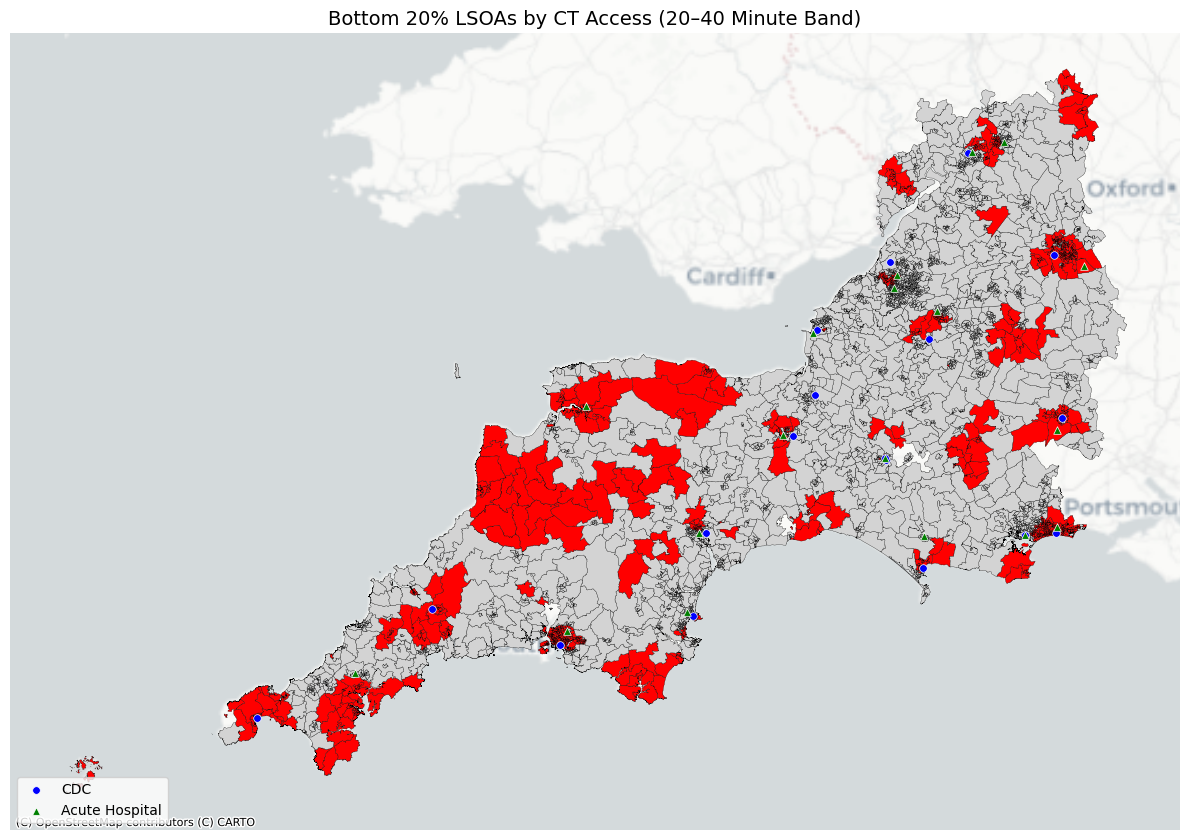

In [13]:
# ----------------------------------------------------------
# Step 3 – Visualise Bottom 20% LSOAs (20–40 Min Access)
# ----------------------------------------------------------

# Define colour mapping for visual tiers
tier_colours = {
    "Bottom 20%": "red",
    "Above 20%": "lightgrey"
}

# Plot setup
fig, ax = plt.subplots(figsize=(12, 10))

# Plot LSOA access tiers
gdf_lsoa_filtered.plot(
    ax=ax,
    column="access_tier",
    color=gdf_lsoa_filtered["access_tier"].map(tier_colours),
    edgecolor="black",
    linewidth=0.2,
    legend=False
)

# Overlay: CDC sites
cdc_gdf.plot(
    ax=ax,
    color="blue",
    marker="o",
    markersize=30,
    edgecolor="white",
    linewidth=0.5,
    label="CDC"
)

# Overlay: Acute sites
acute_gdf.plot(
    ax=ax,
    color="green",
    marker="^",
    markersize=30,
    edgecolor="white",
    linewidth=0.5,
    label="Acute Hospital"
)

# Format
ax.set_title("Bottom 20% LSOAs by CT Access (20–40 Minute Band)", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

# Add basemap
ctx.add_basemap(ax, crs=gdf_lsoa_filtered.crs.to_string(), source=ctx.providers.CartoDB.Positron)

# Final layout
plt.tight_layout()
plt.show()


In [15]:
# ----------------------------------------------------------
# Step 4 – Identify and Select Candidate Site (Demand + Cluster-Based)
# ----------------------------------------------------------

from sklearn.cluster import DBSCAN

# 4.1 – Filter to Bottom 20% only
bottom_20_df = gdf_lsoa_filtered[gdf_lsoa_filtered["access_tier"] == "Bottom 20%"].copy()
print(f"Candidate pool (Bottom 20%): {bottom_20_df.shape[0]} LSOAs")

# 4.2 – Ensure CRS is projected for distance-based clustering
if bottom_20_df.crs.is_geographic:
    bottom_20_df = bottom_20_df.to_crs(epsg=27700)  # British National Grid

# 4.3 – Compute centroids
bottom_20_df["centroid"] = bottom_20_df.geometry.centroid
bottom_20_df["x"] = bottom_20_df["centroid"].x
bottom_20_df["y"] = bottom_20_df["centroid"].y

# 4.4 – Apply DBSCAN clustering (10 km radius, min 3 LSOAs)
coords = bottom_20_df[["x", "y"]].values
db = DBSCAN(eps=10000, min_samples=3).fit(coords)
bottom_20_df["cluster_id"] = db.labels_

# 4.5 – Print summary of clusters
cluster_summary = bottom_20_df["cluster_id"].value_counts().sort_index()
print("Cluster counts (excluding noise):")
print(cluster_summary[cluster_summary.index != -1])

# 4.6 – Select largest cluster (excluding noise)
valid_clusters = cluster_summary[cluster_summary.index != -1]
selected_cluster_id = valid_clusters.idxmax()
print(f"Selected cluster ID: {selected_cluster_id} (size: {valid_clusters.max()})")

cluster_df = bottom_20_df[bottom_20_df["cluster_id"] == selected_cluster_id].copy()

# 4.7 – Rank within cluster by highest CT demand
cluster_df = cluster_df.sort_values("ct_total_demand", ascending=False).reset_index(drop=True)
display(cluster_df[["lsoa21cd", "ct_total_demand", "ct_access_car_20_40"]].head())

# 4.8 – Select top-ranked LSOA in the cluster
candidate_lsoa = cluster_df.iloc[0]
candidate_code = candidate_lsoa["lsoa21cd"]
print(f"Selected candidate LSOA: {candidate_code}")

# 4.9 – Extract centroid coordinates for synthetic site
candidate_geom = candidate_lsoa.geometry.centroid
synthetic_x = candidate_geom.x
synthetic_y = candidate_geom.y
print(f"Centroid coordinates for synthetic site:\n  Easting: {synthetic_x:.1f}\n  Northing: {synthetic_y:.1f}")


Candidate pool (Bottom 20%): 981 LSOAs
Cluster counts (excluding noise):
cluster_id
0     162
1      18
2      15
3      10
4      13
5      39
6      38
7     134
8      45
9      52
10     15
11     15
12     30
13    151
14      3
15     20
16     28
17     11
18     37
19     39
20     31
21     29
22     23
23      5
24     13
Name: count, dtype: int64
Selected cluster ID: 0 (size: 162)


,lsoa21cd,ct_total_demand,ct_access_car_20_40
0,E01015403,410.717617,0.0
1,E01020355,362.717173,0.0
2,E01020366,336.151065,0.0
3,E01015404,334.534351,0.0
4,E01015372,332.050529,0.0


Selected candidate LSOA: E01015403
Centroid coordinates for synthetic site:
  Easting: 406475.2
  Northing: 91171.6


In [16]:
# 4.5b – Compute cluster-level summary metrics
cluster_ranking = (
    bottom_20_df[bottom_20_df["cluster_id"] != -1]
    .groupby("cluster_id")
    .agg(
        cluster_size=("lsoa21cd", "count"),
        total_demand=("ct_total_demand", "sum"),
        mean_access=("ct_access_car_20_40", "mean")
    )
    .sort_values(by=["total_demand", "cluster_size"], ascending=[False, False])
)

# Add cluster ID as a column for display
cluster_ranking = cluster_ranking.reset_index()

# Display ranked clusters
print("Ranked Cluster Summary (sorted by total CT demand):")
display(cluster_ranking)


Ranked Cluster Summary (sorted by total CT demand):


,cluster_id,cluster_size,total_demand,mean_access
0,0,162,31096.958929,0.0
1,13,151,25536.701205,0.0
2,7,134,22015.380145,0.0
3,9,52,9360.803159,0.0
4,19,39,8822.111611,0.0
5,12,30,7745.000538,0.0
6,18,37,7619.944132,0.0
7,8,45,7320.342094,0.0
8,6,38,7212.212134,0.0
9,20,31,7142.446274,0.0


In [17]:
# ----------------------------------------------------------
# Step 4 – Select Top 3 Clusters and Candidate LSOAs
# ----------------------------------------------------------

# 4.1 – Get top 3 cluster IDs by total demand
top_clusters = cluster_ranking.head(3)["cluster_id"].tolist()
print(f"Top 3 selected cluster IDs (by total demand): {top_clusters}")

# 4.2 – Filter bottom_20_df to include only these clusters
top_cluster_df = bottom_20_df[bottom_20_df["cluster_id"].isin(top_clusters)].copy()

# 4.3 – For each cluster, find the highest-demand LSOA
candidate_lsoas = (
    top_cluster_df.sort_values(["cluster_id", "ct_total_demand"], ascending=[True, False])
    .groupby("cluster_id")
    .first()
    .reset_index()
)

# 4.4 – Extract candidate LSOA info
candidate_lsoas["centroid"] = candidate_lsoas.geometry.centroid
candidate_lsoas["x"] = candidate_lsoas["centroid"].x
candidate_lsoas["y"] = candidate_lsoas["centroid"].y

# 4.5 – Final preview
print("Selected candidate LSOAs from top 3 clusters:")
display(candidate_lsoas[["cluster_id", "lsoa21cd", "ct_total_demand", "x", "y"]])


Top 3 selected cluster IDs (by total demand): [0, 13, 7]
Selected candidate LSOAs from top 3 clusters:


,cluster_id,lsoa21cd,ct_total_demand,x,y
0,0,E01015403,410.717617,406475.224710,91171.551988
1,7,E01031966,301.123971,407976.891666,181423.705929
2,13,E01015097,364.933849,251180.828780,60484.524728


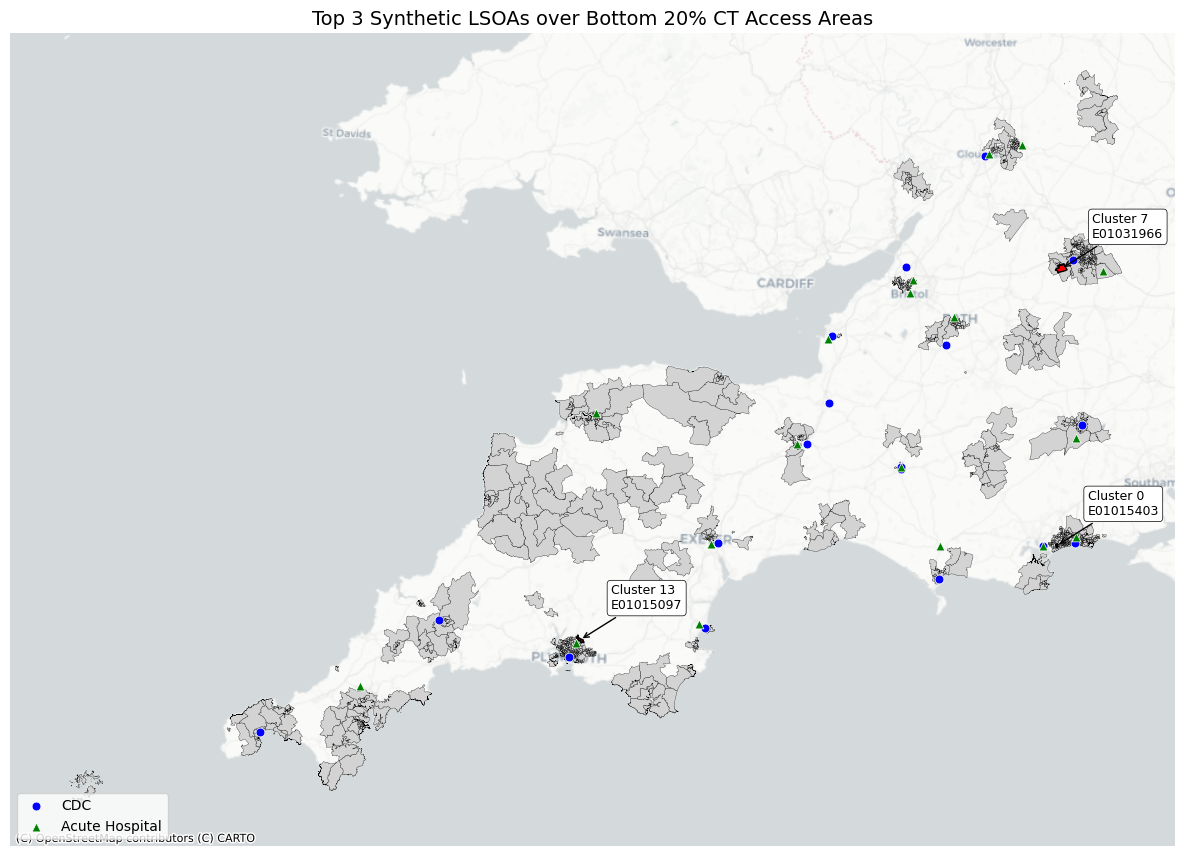

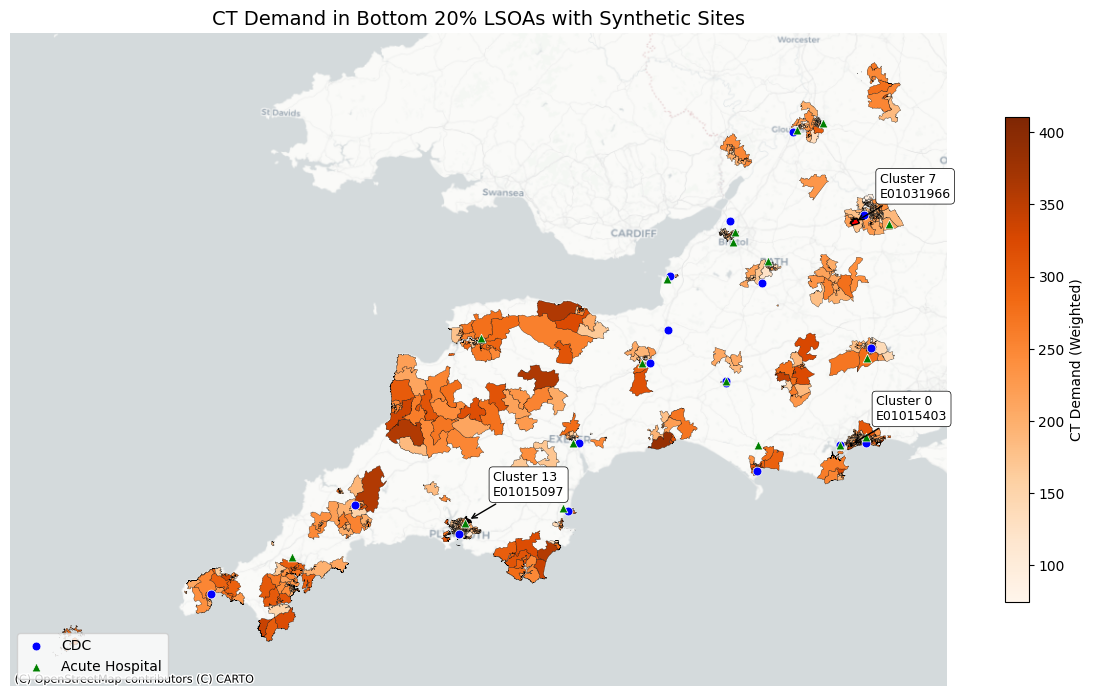

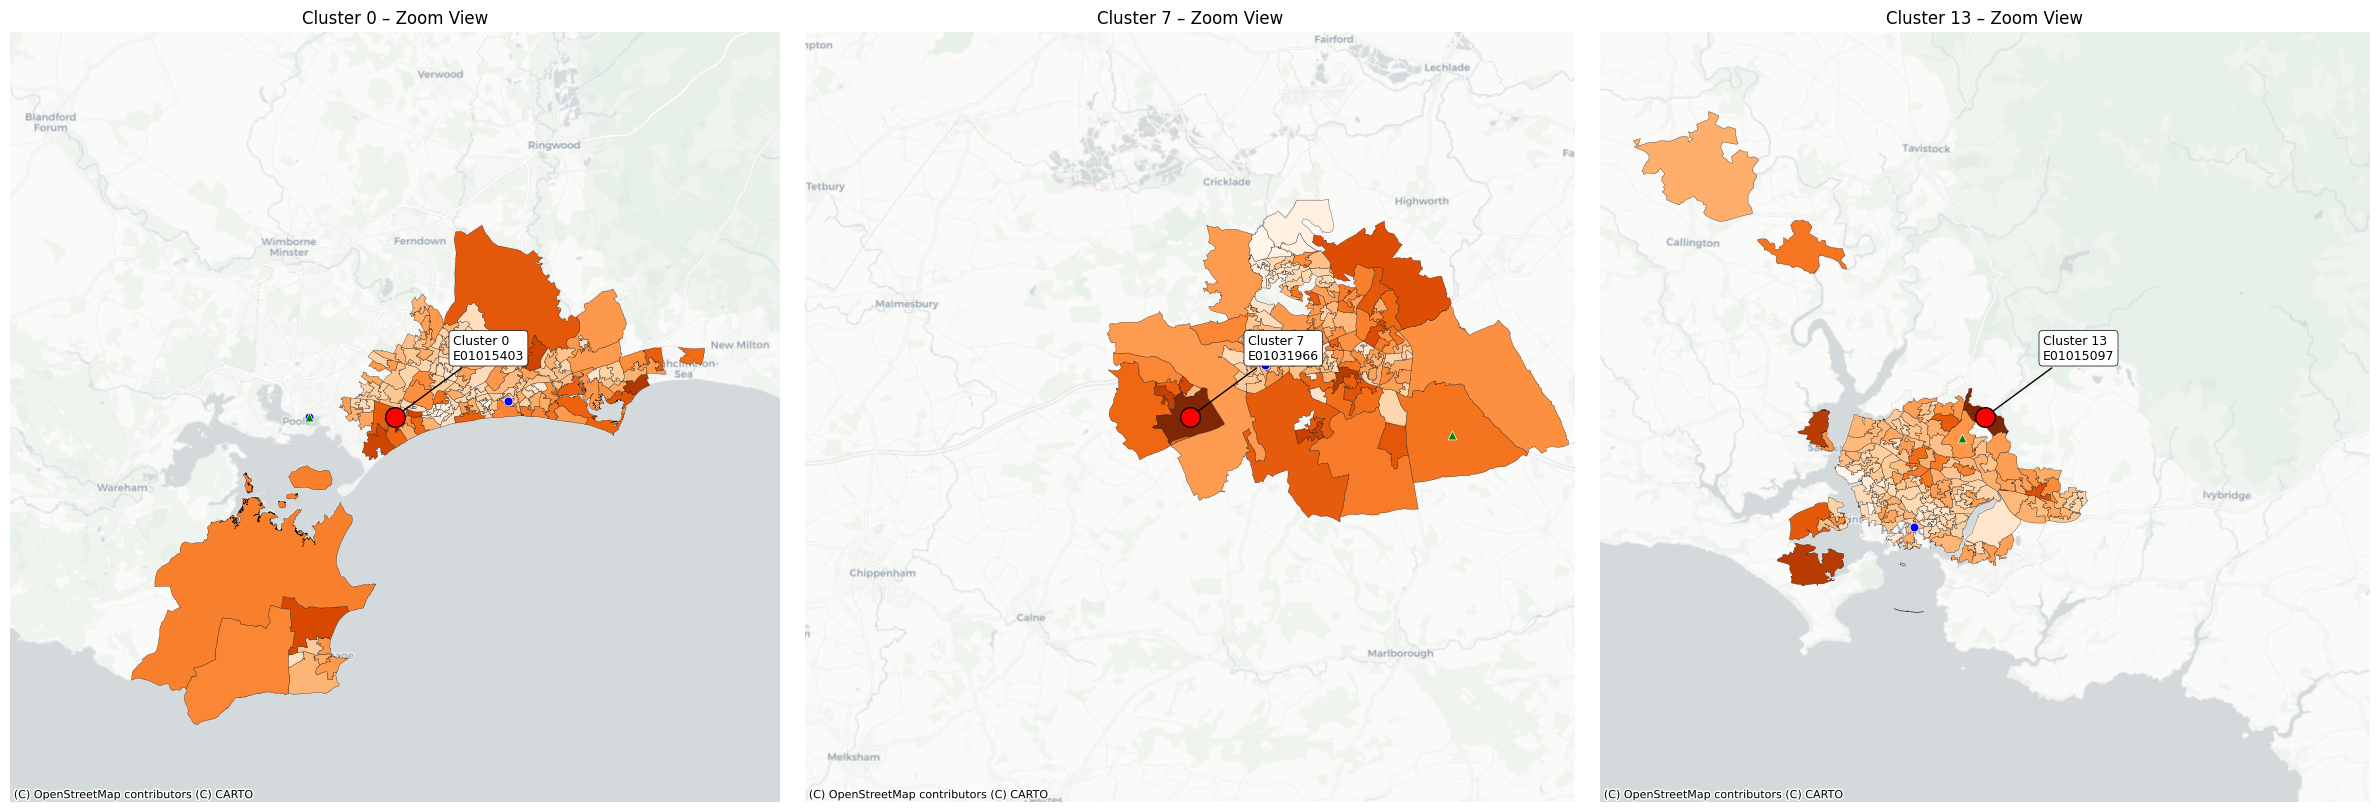

In [32]:
# ----------------------------------------------------------
# Step 4a – Plot Top 3 Candidate LSOAs on Bottom 20% Map (With Arrows)
# ----------------------------------------------------------

# Prepare base: all Bottom 20% LSOAs (light grey)
fig, ax = plt.subplots(figsize=(12, 10))

bottom_20_df.plot(
    ax=ax,
    color="lightgrey",
    edgecolor="black",
    linewidth=0.2,
    label="Bottom 20% LSOAs"
)

# Overlay: selected LSOAs from top 3 clusters (red)
candidate_lsoas.plot(
    ax=ax,
    color="red",
    markersize=150,
    marker="o",
    edgecolor="black",
    linewidth=1,
    label="Selected Synthetic Site"
)

# Add arrows and labels to selected LSOAs
for idx, row in candidate_lsoas.iterrows():
    label_text = f"Cluster {int(row['cluster_id'])}\n{row['lsoa21cd']}"
    ax.annotate(
        text=label_text,
        xy=(row["x"], row["y"]),
        xytext=(row["x"] + 10000, row["y"] + 10000),  # Offset label
        fontsize=9,
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
        ha="left"
    )

# Overlay: CDC sites (blue)
cdc_gdf.plot(
    ax=ax,
    color="blue",
    marker="o",
    markersize=40,
    edgecolor="white",
    linewidth=0.5,
    label="CDC"
)

# Overlay: Acute hospitals (green)
acute_gdf.plot(
    ax=ax,
    color="green",
    marker="^",
    markersize=40,
    edgecolor="white",
    linewidth=0.5,
    label="Acute Hospital"
)

# Final formatting
ax.set_title("Top 3 Synthetic LSOAs over Bottom 20% CT Access Areas", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

# Basemap
ctx.add_basemap(ax, crs=bottom_20_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Step 4a – CT Demand Map (Bottom 20% LSOAs + Synthetic Sites)
# ----------------------------------------------------------

# Setup single-plot figure
fig, ax = plt.subplots(figsize=(12, 10))

# Plot Bottom 20% LSOAs with CT demand choropleth
bottom_20_df.plot(
    ax=ax,
    column="ct_total_demand",
    cmap="Oranges",
    edgecolor="black",
    linewidth=0.2,
    legend=True,
    legend_kwds={"label": "CT Demand (Weighted)", "shrink": 0.5}
)

# Overlay synthetic site locations
candidate_lsoas.plot(
    ax=ax,
    color="red",
    marker="o",
    markersize=150,
    edgecolor="black",
    linewidth=1,
    label="Synthetic Site"
)

# Add arrow annotations
for idx, row in candidate_lsoas.iterrows():
    ax.annotate(
        text=f"Cluster {int(row['cluster_id'])}\n{row['lsoa21cd']}",
        xy=(row["x"], row["y"]),
        xytext=(row["x"] + 10000, row["y"] + 10000),
        fontsize=9,
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
        ha="left"
    )

# Overlay CDCs and Acute sites
cdc_gdf.plot(ax=ax, color="blue", marker="o", markersize=40, edgecolor="white", linewidth=0.5, label="CDC")
acute_gdf.plot(ax=ax, color="green", marker="^", markersize=40, edgecolor="white", linewidth=0.5, label="Acute Hospital")

# Final formatting
ax.set_title("CT Demand in Bottom 20% LSOAs with Synthetic Sites", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

# Add basemap
ctx.add_basemap(ax, crs=bottom_20_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()

# ----------------------------------------------------------
# Step 4b – Zoomed Maps of Top 3 Clusters and Synthetic Sites
# ----------------------------------------------------------

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8), sharex=False, sharey=False)

buffer_dist = 20000  # 20 km buffer around centroid

for ax, (idx, row) in zip(axes, candidate_lsoas.iterrows()):
    cluster_id = row["cluster_id"]
    lsoa_code = row["lsoa21cd"]
    cx, cy = row["x"], row["y"]

    # Subset cluster LSOAs
    cluster_gdf = bottom_20_df[bottom_20_df["cluster_id"] == cluster_id]

    # Base: cluster LSOAs with CT demand
    cluster_gdf.plot(
        ax=ax,
        column="ct_total_demand",
        cmap="Oranges",
        edgecolor="black",
        linewidth=0.2,
        legend=False
    )

    # Highlight synthetic LSOA
    ax.scatter(cx, cy, s=200, c="red", edgecolor="black", label="Synthetic Site", zorder=5)

    ax.annotate(
        f"Cluster {int(cluster_id)}\n{lsoa_code}",
        xy=(cx, cy),
        xytext=(cx + 3000, cy + 3000),
        fontsize=9,
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
        ha="left"
    )

    # Overlay local CDC and Acute sites (within ~30 km)
    local_cdc = cdc_gdf.cx[cx - 30000: cx + 30000, cy - 30000: cy + 30000]
    local_acute = acute_gdf.cx[cx - 30000: cx + 30000, cy - 30000: cy + 30000]

    local_cdc.plot(ax=ax, color="blue", marker="o", markersize=40, edgecolor="white", linewidth=0.5, label="CDC")
    local_acute.plot(ax=ax, color="green", marker="^", markersize=40, edgecolor="white", linewidth=0.5, label="Acute Hospital")

    # Set zoom extent
    ax.set_xlim(cx - buffer_dist, cx + buffer_dist)
    ax.set_ylim(cy - buffer_dist, cy + buffer_dist)

    ax.set_title(f"Cluster {int(cluster_id)} – Zoom View", fontsize=12)
    ax.axis("off")
    ctx.add_basemap(ax, crs=bottom_20_df.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()





In [21]:
# ----------------------------------------------------------
# Step 5 – Simulate New CT Scanner Sites
# ----------------------------------------------------------

# 5.1 – Create synthetic site records for each selected LSOA
synthetic_sites = []

for idx, row in candidate_lsoas.iterrows():
    synthetic_site = {
        "Code": f"SYNTH_{idx+1}",
        "Name": f"Synthetic CT Site {idx+1}",
        "CT Scanners": 1,
        "Type": "Synthetic",
        "lsoa21cd": row["lsoa21cd"]
    }
    synthetic_sites.append(synthetic_site)

# Convert to DataFrame
df_synthetic = pd.DataFrame(synthetic_sites)

# 5.2 – Combine with existing df_sites
df_sites_scenario = pd.concat([df_sites, df_synthetic], ignore_index=True)

# 5.3 – Recalculate scanner supply per destination LSOA
scanner_supply_scenario = (
    df_sites_scenario[["lsoa21cd", "CT Scanners"]]
    .groupby("lsoa21cd", as_index=False)
    .sum()
    .rename(columns={"lsoa21cd": "destination_name", "CT Scanners": "ct_scanner_supply"})
)

# 5.4 – Merge updated supply into the travel matrix
df_travel_supply_scenario = df_travel.copy()

df_travel_supply_scenario = df_travel_supply_scenario.merge(
    scanner_supply_scenario,
    on="destination_name",
    how="left"
)

# Fill missing scanner values with 0
df_travel_supply_scenario["ct_scanner_supply"] = df_travel_supply_scenario["ct_scanner_supply"].fillna(0)

# Preview
print(f"Updated travel matrix shape: {df_travel_supply_scenario.shape}")
display(df_travel_supply_scenario.head())


Updated travel matrix shape: (11003925, 6)


,origin_name,destination_name,travel_time_car,travel_time_pt_peak,travel_time_pt_nonpeak,ct_scanner_supply
0,E01022150,E01014950,42.748168,56.288168,56.288168,0.0
1,E01029238,E01033364,85.033922,126.483922,126.483922,0.0
2,E01014654,E01015202,123.315531,148.025531,146.985531,0.0
3,E01015028,E01029066,133.568645,268.518645,255.878645,0.0
4,E01015316,E01029066,112.233260,221.623260,227.623260,0.0


In [24]:
# ----------------------------------------------------------
# Step 6 – Recompute Accessibility Scores (Scenario)
# ----------------------------------------------------------

# 6.1 – Recreate time band flags using travel_time_car
df_travel_supply_scenario["lt_20"] = df_travel_supply_scenario["travel_time_car"] < 20
df_travel_supply_scenario["20_40"] = df_travel_supply_scenario["travel_time_car"].between(20, 40, inclusive="left")
df_travel_supply_scenario["gt_40"] = df_travel_supply_scenario["travel_time_car"] > 40

# 6.2 – Initialise accessibility DataFrame by origin LSOA
access_df_scenario = df_travel_supply_scenario[["origin_name"]].drop_duplicates().set_index("origin_name")

# 6.3 – Group and sum scanner supply for each band
lt20_s = df_travel_supply_scenario[df_travel_supply_scenario["lt_20"]].groupby("origin_name")["ct_scanner_supply"].sum()
btw2040_s = df_travel_supply_scenario[df_travel_supply_scenario["20_40"]].groupby("origin_name")["ct_scanner_supply"].sum()
gt40_s = df_travel_supply_scenario[df_travel_supply_scenario["gt_40"]].groupby("origin_name")["ct_scanner_supply"].sum()

# 6.4 – Join and rename columns
access_df_scenario["ct_access_car_lt_20"] = lt20_s
access_df_scenario["ct_access_car_20_40"] = btw2040_s
access_df_scenario["ct_access_car_gt_40"] = gt40_s

access_df_scenario = access_df_scenario.fillna(0).reset_index().rename(columns={"origin_name": "lsoa21cd"})

# 6.5 – Merge with base LSOA geometry and demand
gdf_base = gpd.read_file(lsoa_gpkg_path)[["lsoa21cd", "geometry", "ct_total_demand", "total_population"]]
gdf_lsoa_scenario = gdf_base.merge(access_df_scenario, on="lsoa21cd", how="left")

# 6.6 – Fill unmatched with zeros
gdf_lsoa_scenario[["ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]] = (
    gdf_lsoa_scenario[["ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]].fillna(0)
)

# Preview
print("Sample of updated scenario accessibility scores:")
display(gdf_lsoa_scenario[["lsoa21cd", "ct_access_car_lt_20", "ct_access_car_20_40", "ct_access_car_gt_40"]].head())


Sample of updated scenario accessibility scores:


,lsoa21cd,ct_access_car_lt_20,ct_access_car_20_40,ct_access_car_gt_40
0,E01020484,0.0,0.0,63.0
1,E01020481,0.0,0.0,63.0
2,E01020482,0.0,0.0,63.0
3,E01020479,0.0,0.0,63.0
4,E01020478,0.0,0.0,63.0


In [25]:
# ----------------------------------------------------------
# Step 7 – Integrate Age-Based Demand Weighting
# ----------------------------------------------------------

# 7.1 – Check demand column exists in both GeoDataFrames
assert "ct_total_demand" in gdf_lsoa.columns, "Missing ct_total_demand in baseline"
assert "ct_total_demand" in gdf_lsoa_scenario.columns, "Missing ct_total_demand in scenario"

# 7.2 – Create demand-adjusted access scores in baseline
gdf_lsoa["ct_access_weighted_lt_20"] = gdf_lsoa["ct_access_car_lt_20"] * gdf_lsoa["ct_total_demand"]
gdf_lsoa["ct_access_weighted_20_40"] = gdf_lsoa["ct_access_car_20_40"] * gdf_lsoa["ct_total_demand"]
gdf_lsoa["ct_access_weighted_gt_40"] = gdf_lsoa["ct_access_car_gt_40"] * gdf_lsoa["ct_total_demand"]

# 7.3 – Create demand-adjusted access scores in scenario
gdf_lsoa_scenario["ct_access_weighted_lt_20"] = gdf_lsoa_scenario["ct_access_car_lt_20"] * gdf_lsoa_scenario["ct_total_demand"]
gdf_lsoa_scenario["ct_access_weighted_20_40"] = gdf_lsoa_scenario["ct_access_car_20_40"] * gdf_lsoa_scenario["ct_total_demand"]
gdf_lsoa_scenario["ct_access_weighted_gt_40"] = gdf_lsoa_scenario["ct_access_car_gt_40"] * gdf_lsoa_scenario["ct_total_demand"]

# 7.4 – Preview weighted scenario vs baseline
print("Preview of demand-weighted access scores (scenario):")
display(gdf_lsoa_scenario[[
    "lsoa21cd",
    "ct_total_demand",
    "ct_access_weighted_lt_20",
    "ct_access_weighted_20_40",
    "ct_access_weighted_gt_40"
]].head())


Preview of demand-weighted access scores (scenario):


,lsoa21cd,ct_total_demand,ct_access_weighted_lt_20,ct_access_weighted_20_40,ct_access_weighted_gt_40
0,E01020484,195.135416,0.0,0.0,12293.531229
1,E01020481,229.178298,0.0,0.0,14438.232789
2,E01020482,208.131320,0.0,0.0,13112.273173
3,E01020479,236.957728,0.0,0.0,14928.336836
4,E01020478,167.844266,0.0,0.0,10574.188757


In [26]:
# ----------------------------------------------------------
# Step 8 – Impact Analysis of Scenario vs Baseline
# ----------------------------------------------------------

# 8.1 – Merge baseline and scenario scores into a comparison DataFrame
compare_df = gdf_lsoa[["lsoa21cd", "ct_access_car_20_40", "ct_access_weighted_20_40"]].copy()
compare_df = compare_df.rename(columns={
    "ct_access_car_20_40": "access_20_40_baseline",
    "ct_access_weighted_20_40": "access_weighted_20_40_baseline"
})

compare_df = compare_df.merge(
    gdf_lsoa_scenario[["lsoa21cd", "ct_access_car_20_40", "ct_access_weighted_20_40"]],
    on="lsoa21cd",
    how="left",
    suffixes=("", "_scenario")
)

compare_df = compare_df.rename(columns={
    "ct_access_car_20_40": "access_20_40_scenario",
    "ct_access_weighted_20_40": "access_weighted_20_40_scenario"
})

# 8.2 – Calculate differences
compare_df["access_20_40_diff"] = compare_df["access_20_40_scenario"] - compare_df["access_20_40_baseline"]
compare_df["access_weighted_20_40_diff"] = compare_df["access_weighted_20_40_scenario"] - compare_df["access_weighted_20_40_baseline"]

# 8.3 – Summary statistics
mean_diff = compare_df["access_20_40_diff"].mean()
total_improved = (compare_df["access_20_40_diff"] > 0).sum()
total_lsoas = compare_df.shape[0]
weighted_gain = compare_df["access_weighted_20_40_diff"].sum()

print(f"Mean increase in raw 20–40 min access: {mean_diff:.2f}")
print(f"Number of LSOAs with improved access: {total_improved} / {total_lsoas}")
print(f"Total demand-weighted access gained: {weighted_gain:,.2f}")

# 8.4 – Preview top 10 improved LSOAs
compare_df_sorted = compare_df.sort_values("access_weighted_20_40_diff", ascending=False)
display(compare_df_sorted[[
    "lsoa21cd", 
    "access_20_40_baseline", 
    "access_20_40_scenario", 
    "access_20_40_diff",
    "access_weighted_20_40_diff"
]].head(10))


Mean increase in raw 20–40 min access: 0.12
Number of LSOAs with improved access: 412 / 3451
Total demand-weighted access gained: 84,242.51


,lsoa21cd,access_20_40_baseline,access_20_40_scenario,access_20_40_diff,access_weighted_20_40_diff
199,E01020406,3.0,4.0,1.0,463.373080
187,E01020395,1.0,2.0,1.0,424.977338
419,E01020350,4.0,5.0,1.0,420.880114
420,E01020349,1.0,2.0,1.0,418.514200
884,E01031861,4.0,5.0,1.0,388.218141
417,E01020355,0.0,1.0,1.0,362.717173
701,E01031918,7.0,8.0,1.0,357.468899
2140,E01020161,6.0,7.0,1.0,345.612083
196,E01020422,4.0,5.0,1.0,338.335743
459,E01020398,4.0,5.0,1.0,335.293555


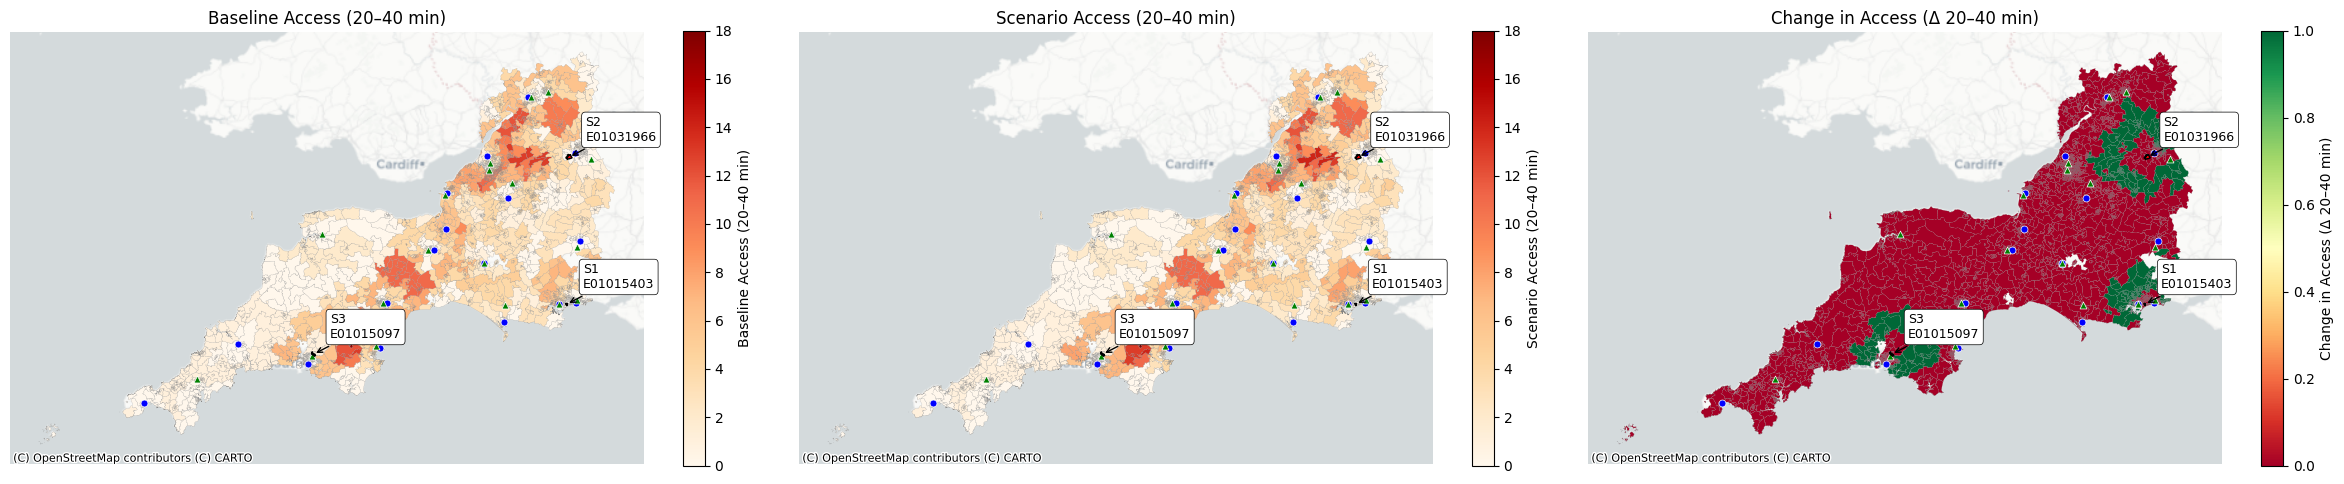

In [28]:
# ----------------------------------------------------------
# Step 9 – Visualise Before / After / Change (20–40 Min Access)
# ----------------------------------------------------------

# Merge baseline and scenario scores
gdf_compare = gdf_lsoa[["lsoa21cd", "geometry", "ct_access_car_20_40"]].copy()
gdf_compare = gdf_compare.rename(columns={"ct_access_car_20_40": "access_20_40_baseline"})

gdf_compare = gdf_compare.merge(
    gdf_lsoa_scenario[["lsoa21cd", "ct_access_car_20_40"]],
    on="lsoa21cd", how="left"
).rename(columns={"ct_access_car_20_40": "access_20_40_scenario"})

# Calculate difference
gdf_compare["access_20_40_diff"] = gdf_compare["access_20_40_scenario"] - gdf_compare["access_20_40_baseline"]

# Set consistent min/max for both baseline and scenario maps
vmin = min(gdf_compare["access_20_40_baseline"].min(), gdf_compare["access_20_40_scenario"].min())
vmax = max(gdf_compare["access_20_40_baseline"].max(), gdf_compare["access_20_40_scenario"].max())

# Plot setup
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 9), sharex=True, sharey=True)

# Define column mappings and titles
columns = {
    "access_20_40_baseline": "Baseline Access (20–40 min)",
    "access_20_40_scenario": "Scenario Access (20–40 min)",
    "access_20_40_diff": "Change in Access (Δ 20–40 min)"
}

# Plot each map
for ax, (col, title) in zip(axes, columns.items()):
    gdf_compare.plot(
        ax=ax,
        column=col,
        cmap="RdYlGn" if "diff" in col else "OrRd",
        vmin=vmin if "diff" not in col else None,
        vmax=vmax if "diff" not in col else None,
        linewidth=0.1,
        edgecolor="grey",
        legend=True,
        legend_kwds={"label": title, "shrink": 0.5},
    )

    # Overlay: CDC and Acute
    cdc_gdf.plot(ax=ax, color="blue", markersize=25, marker="o", edgecolor="white", linewidth=0.5)
    acute_gdf.plot(ax=ax, color="green", markersize=25, marker="^", edgecolor="white", linewidth=0.5)

    # Overlay: Synthetic LSOAs (from Step 4)
    candidate_lsoas.plot(ax=ax, color="red", marker="o", markersize=80, edgecolor="black", label="Synthetic")

    # Add arrows pointing to synthetic sites
    for i, row in candidate_lsoas.iterrows():
        ax.annotate(
            f"S{i+1}\n{row['lsoa21cd']}",
            xy=(row["x"], row["y"]),
            xytext=(row["x"] + 10000, row["y"] + 10000),
            fontsize=9,
            arrowprops=dict(arrowstyle="->", color="black", lw=1),
            bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
            ha="left"
        )

    ax.set_title(title, fontsize=12)
    ax.axis("off")
    ctx.add_basemap(ax, crs=gdf_compare.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()


# CT Scanner Accessibility Scenario Modelling – Summary

This notebook extends the baseline accessibility model to simulate the impact of adding three new CT scanner sites in underserved areas across the South West region. The approach follows a **Core20+5-inspired** logic, focusing on LSOAs with poor access in the **20–40 minute travel band**.

---

## Methodology Overview

### 1. Baseline Access
- Accessibility scores were calculated for each LSOA, based on proximity to existing CT scanners in CDC and Acute hospitals.
- Three travel time bands were considered:  
  - `<20 mins`  
  - `20–40 mins`  
  - `>40 mins` by car

### 2. Underserved Area Identification
- LSOAs in the bottom 20% of access scores for the 20–40 min band were flagged.
- Spatial clustering (**DBSCAN**) identified geographic groupings of underserved LSOAs.

### 3. Synthetic Site Selection
- From the top 3 underserved clusters (by total CT demand), one LSOA per cluster was selected to simulate a synthetic CT scanner site.

### 4. Impact Simulation
- The synthetic sites were added to the facility dataset.
- Accessibility scores were recalculated using the updated travel matrix.
- Changes were evaluated both in raw scanner access and demand-weighted terms (based on `ct_total_demand`).

---

## Key Results

| Metric                       | Value         |
|-----------------------------|---------------|
| Synthetic Sites Added       | 3             |
| LSOAs with Improved Access  | 412 of 3,451  |
| Mean Increase in 20–40 Min Access | +0.12 scanners |
| Total Demand-Weighted Gain  | 84,242.51     |

---

## Visual Outputs

- **Step 4a Map**: Bottom 20% LSOAs with synthetic site annotations.
- **Step 9 Maps**: Side-by-side comparison of:
  - Baseline access  
  - Scenario access  
  - Change in access (Δ)

---

This simulation demonstrates how **targeted investment** in underserved clusters can **measurably improve** regional access to CT diagnostic services — particularly in **high-demand, low-access** areas.


Number of LSOAs with improved 20–40 min access: 412


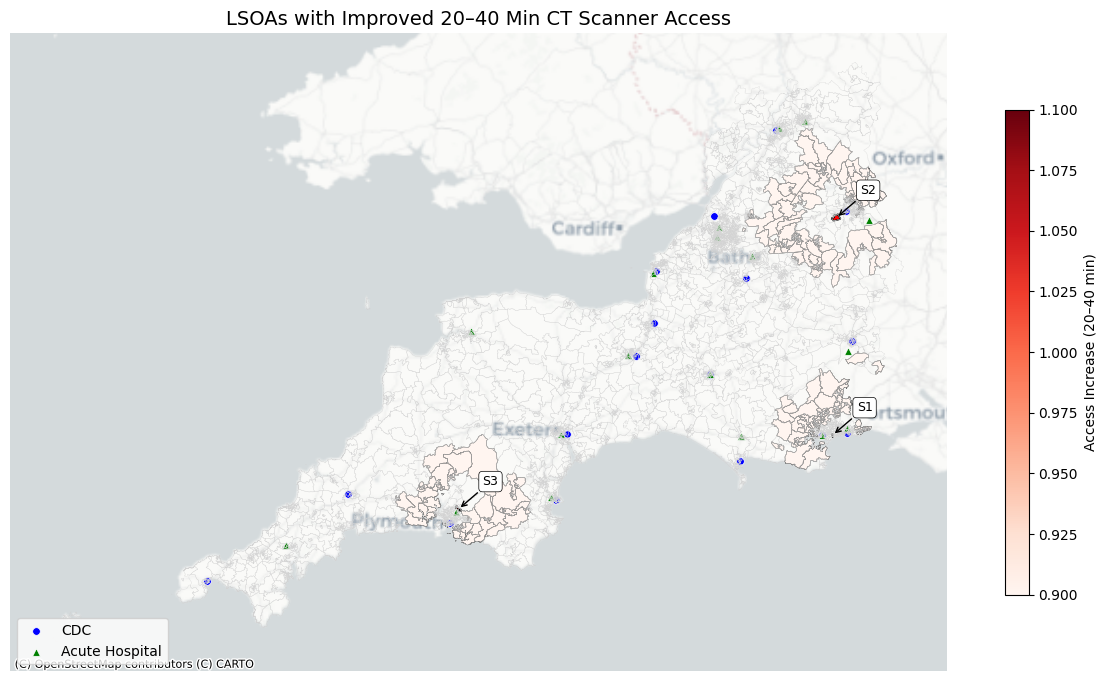

In [29]:
# ----------------------------------------------------------
# Step 10 – Highlight LSOAs with Improved 20–40 Min Access
# ----------------------------------------------------------

# 10.1 – Filter LSOAs that saw an increase in 20–40 min access
gdf_beneficiaries = gdf_compare[gdf_compare["access_20_40_diff"] > 0].copy()
print(f"Number of LSOAs with improved 20–40 min access: {gdf_beneficiaries.shape[0]}")

# 10.2 – Plot
fig, ax = plt.subplots(figsize=(12, 10))

# Base map: all LSOA boundaries for context
gdf_compare.boundary.plot(ax=ax, color='lightgrey', linewidth=0.2)

# Highlight: LSOAs with access gain
gdf_beneficiaries.plot(
    ax=ax,
    column="access_20_40_diff",
    cmap="Reds",
    edgecolor="black",
    linewidth=0.3,
    legend=True,
    legend_kwds={"label": "Access Increase (20–40 min)", "shrink": 0.5}
)

# Overlay: synthetic sites
candidate_lsoas.plot(ax=ax, color="red", marker="o", markersize=80, edgecolor="black", label="Synthetic Site")

# Overlay: CDCs and Acute sites
cdc_gdf.plot(ax=ax, color="blue", marker="o", markersize=30, edgecolor="white", linewidth=0.5, label="CDC")
acute_gdf.plot(ax=ax, color="green", marker="^", markersize=30, edgecolor="white", linewidth=0.5, label="Acute Hospital")

# Add arrows to synthetic sites
for i, row in candidate_lsoas.iterrows():
    ax.annotate(
        f"S{i+1}",
        xy=(row["x"], row["y"]),
        xytext=(row["x"] + 10000, row["y"] + 10000),
        fontsize=9,
        arrowprops=dict(arrowstyle="->", color="black", lw=1),
        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=0.5),
        ha="left"
    )

# Final formatting
ax.set_title("LSOAs with Improved 20–40 Min CT Scanner Access", fontsize=14)
ax.axis("off")
ax.legend(loc="lower left", frameon=True)

# Basemap
ctx.add_basemap(ax, crs=gdf_compare.crs.to_string(), source=ctx.providers.CartoDB.Positron)

plt.tight_layout()
plt.show()
